In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set_style('darkgrid')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


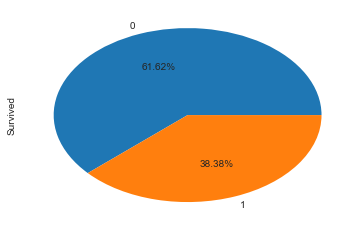

In [5]:
train_data['Survived'].value_counts().plot(kind='pie', autopct='%1.2f%%');

## 补全数据
将`Embarked`这一栏缺失的值用最多的一个值来代替

In [6]:
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

将`Cabin`这一栏缺失的值用`U0`来代替，代表Unknown

In [7]:
train_data.Cabin = train_data.Cabin.fillna('U0')

将Age这一栏缺失的值利用回归算法得出的值替代，这里用随机森林做回归算法的模型

In [8]:
from sklearn.ensemble import RandomForestRegressor

age_df = train_data[['Age', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Fare']]
age_notnull = age_df.loc[(train_data['Age'].notnull())]
age_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_notnull.values[:, 1:]
y = age_notnull.values[:, 0]
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X, y)
predict_ages = RFR.predict(age_isnull.values[:, 1:])
train_data.loc[train_data.Age.isnull(), ['Age']] = predict_ages

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 分析数据

### Sex vs. Survived

In [10]:
train_data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

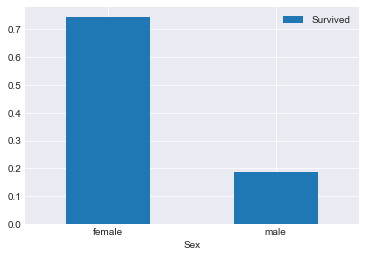

In [11]:
# 画出每个性别具体存活人数
# sns.countplot('Sex', data=train_data[train_data.Survived == 1]);
# sns.factorplot(x='Sex', data=train_data, col='Survived', kind='count');

# 求每个性别的存活率
# 这个地方用mean来算存活率真是非常精妙的一步，写法既简洁又易懂
train_data[['Sex', 'Survived']].groupby('Sex').mean().plot(kind='bar', rot=0);

### Pclass vs. Survived

In [12]:
train_data.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

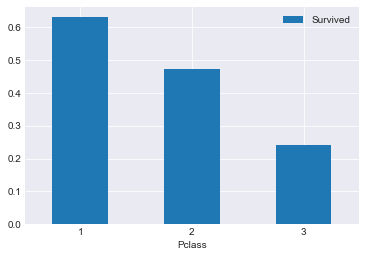

In [13]:
# sns.countplot('Pclass', data=train_data[train_data.Survived == 1]);

train_data[['Pclass', 'Survived']].groupby('Pclass').mean().plot(kind='bar', rot=0);

### Age vs. Survived

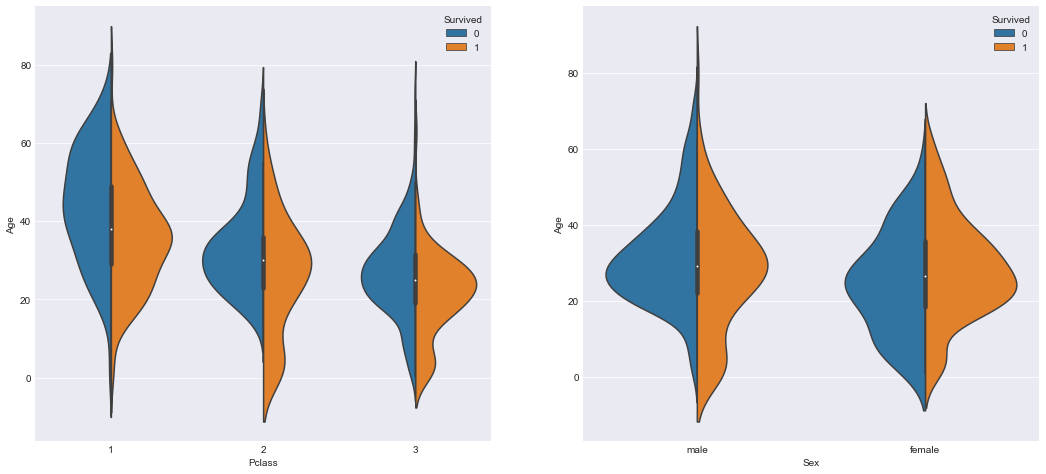

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot("Pclass", "Age", hue="Survived", data=train_data, split=True, ax=ax[0])
sns.violinplot("Sex", "Age", hue="Survived", data=train_data, split=True, ax=ax[1])
plt.show();

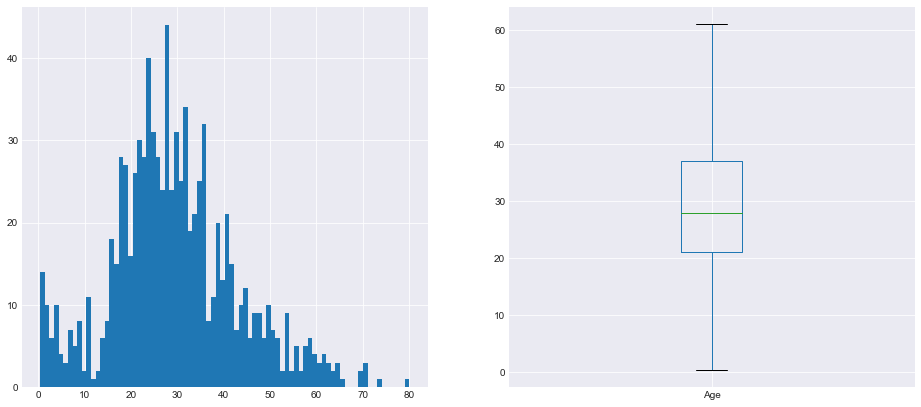

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
train_data['Age'].hist(bins=80, ax=ax[0])
train_data['Age'].plot(kind='box', ax=ax[1], showfliers=False)
plt.show();

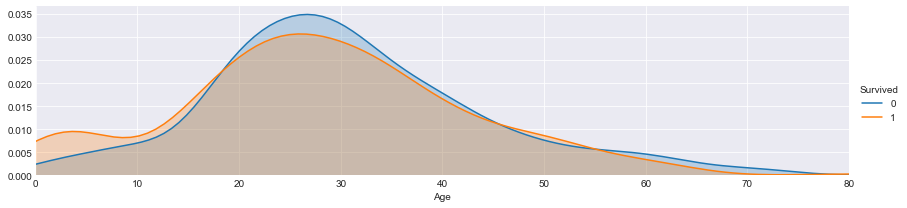

In [16]:
facet = sns.FacetGrid(train_data, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

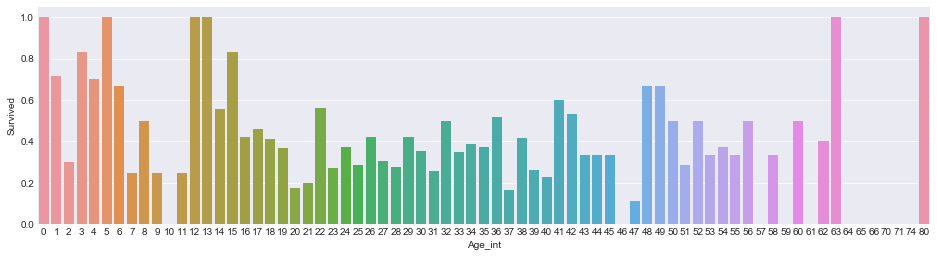

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
train_data['Age_int'] = train_data['Age'].astype(int)
average_age = train_data[['Age_int', 'Survived']].groupby('Age_int', as_index=False).mean()
sns.barplot('Age_int', 'Survived', data=average_age);

### Name vs. Survived

In [18]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


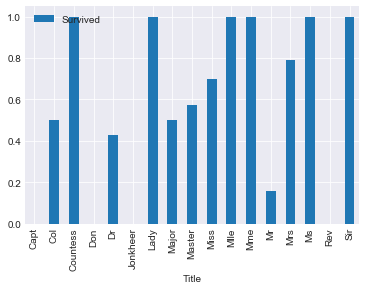

In [19]:
train_data[['Title', 'Survived']].groupby('Title').mean().plot(kind='bar');

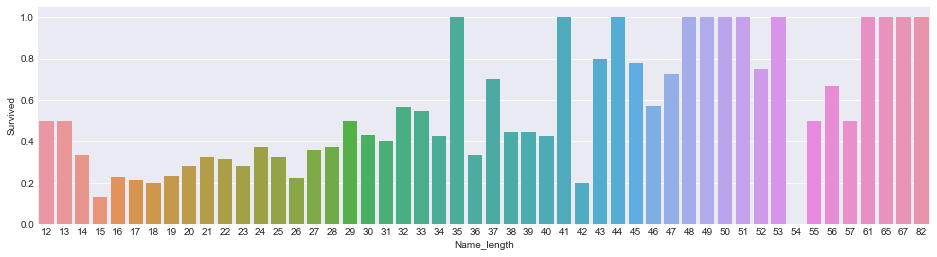

In [20]:
train_data['Name_length'] = train_data['Name'].apply(len)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
name_length = train_data[['Name_length', 'Survived']].groupby('Name_length', as_index=False).mean()
sns.barplot('Name_length', 'Survived', data=name_length);

### SibSp vs. Survived

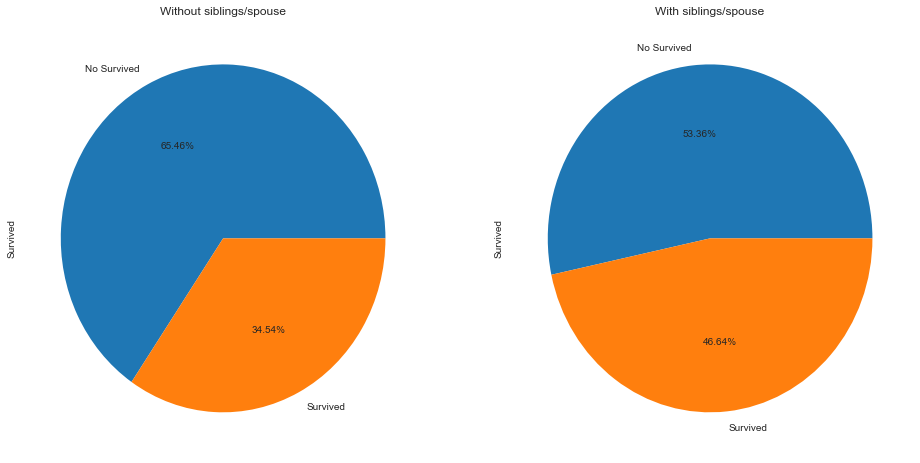

In [21]:
no_sib = train_data[train_data['SibSp'] == 0]['Survived'].value_counts()
sib = train_data[train_data['SibSp'] != 0]['Survived'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
no_sib.plot(kind='pie', title='Without siblings/spouse', labels=['No Survived', 'Survived'], autopct='%1.2f%%',  ax=ax[0])
sib.plot(kind='pie', title='With siblings/spouse', labels=['No Survived', 'Survived'], autopct='%1.2f%%', ax=ax[1])
plt.show();

### Parch vs. Survived

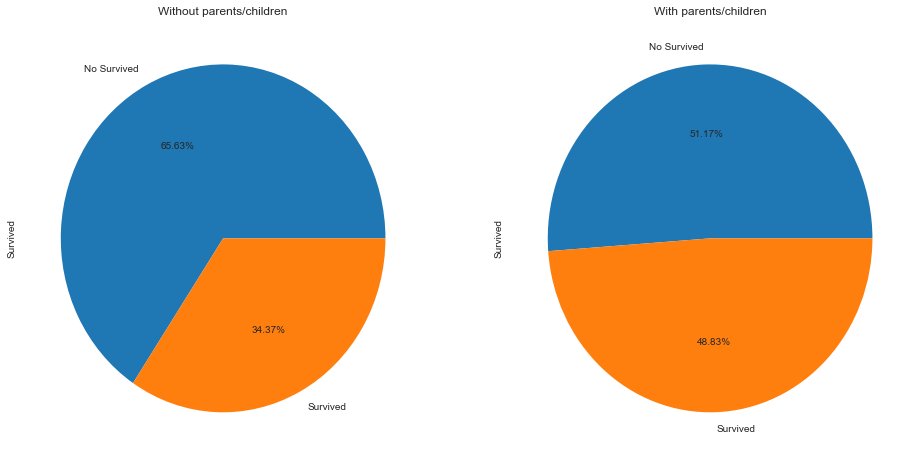

In [22]:
no_par = train_data[train_data['Parch'] == 0]['Survived'].value_counts()
par = train_data[train_data['Parch'] != 0]['Survived'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
no_par.plot(kind='pie', title='Without parents/children', labels=['No Survived', 'Survived'], autopct='%1.2f%%',  ax=ax[0])
par.plot(kind='pie', title='With parents/children', labels=['No Survived', 'Survived'], autopct='%1.2f%%', ax=ax[1])
plt.show();

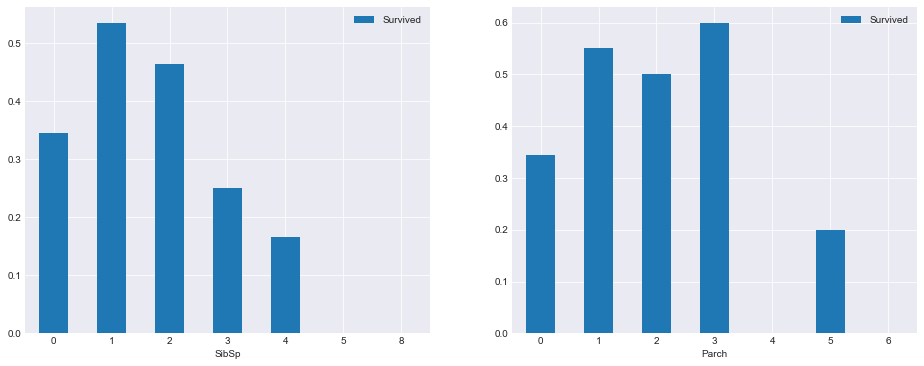

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
train_data[['SibSp', 'Survived']].groupby('SibSp').mean().plot(kind='bar', ax=ax[0], rot=0)
train_data[['Parch', 'Survived']].groupby('Parch').mean().plot(kind='bar', ax=ax[1], rot=0)
plt.show();

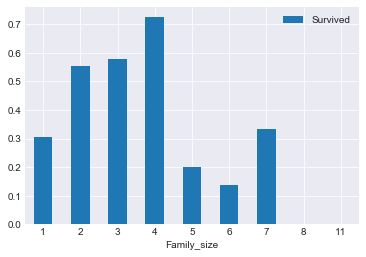

In [24]:
train_data['Family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data[['Family_size', 'Survived']].groupby('Family_size').mean().plot(kind='bar', rot=0);

### Fare vs. Survived

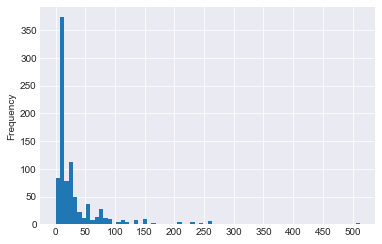

In [25]:
train_data['Fare'].plot(kind='hist', bins=70, xticks=range(0, 550, 50));

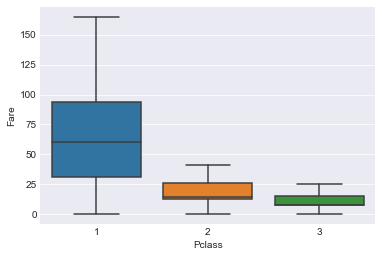

In [26]:
sns.boxplot(y='Fare', x='Pclass', data=train_data, showfliers=False);

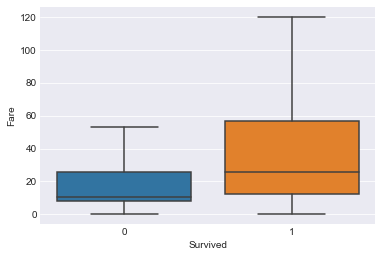

In [27]:
sns.boxplot(x='Survived', y='Fare', data=train_data, showfliers=False);

### Cabin vs. Survived

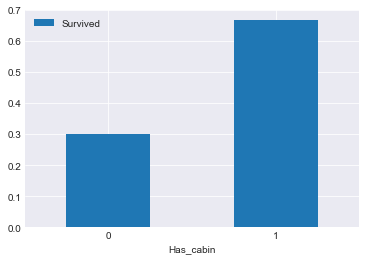

In [28]:
train_data['Has_cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_cabin', 'Survived']].groupby('Has_cabin').mean().plot(kind='bar', rot=0);

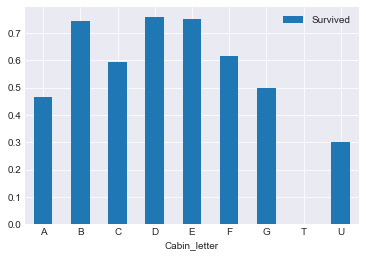

In [29]:
import re
cabin_letter = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
train_data['Cabin_letter'] = cabin_letter
train_data[['Cabin_letter', 'Survived']].groupby('Cabin_letter').mean().plot(kind='bar', rot=0);

### Embarked vs. Survived

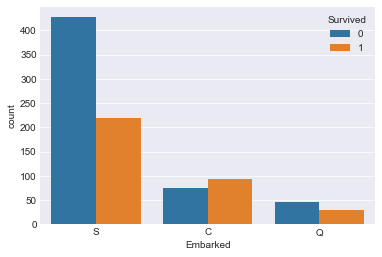

In [30]:
sns.countplot('Embarked', hue='Survived', data=train_data);

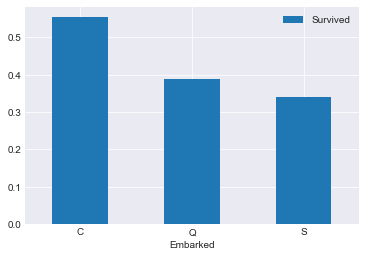

In [31]:
train_data[['Embarked', 'Survived']].groupby('Embarked').mean().plot(kind='bar', rot=0);

## Data Preprocessing

### Embarked into dummies

In [32]:
embark_dummy = pd.get_dummies(train_data['Embarked'])
# train_data = train_data.join(embark_dummy)

In [33]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_int', 'Title',
       'Name_length', 'Family_size', 'Has_cabin', 'Cabin_letter'],
      dtype='object')

### Scaling Age

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].reshape(-1, 1))

In [35]:
train_data['Age_scaled'].head()

0   -0.557918
1    0.607262
2   -0.266623
3    0.388791
4    0.388791
Name: Age_scaled, dtype: float64

### Binning Fare

In [36]:
fare_bins = pd.qcut(train_data['Fare'], 5)
train_data['Fare_bins'] = pd.factorize(fare_bins)[0]

## Feature Engineering

In [37]:
train_df_org = pd.read_csv("train.csv")
test_df_org = pd.read_csv("test.csv")
test_df_org['Survived'] = 0
train_test = train_df_org.append(test_df_org)
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


In [38]:
train_test['Embarked'].fillna(train_test['Embarked'].mode()[0], inplace=True)

In [39]:
train_test['Embarked'] = pd.factorize(train_test['Embarked'])[0]
emb_dummies_df = pd.get_dummies(train_test['Embarked'], prefix=train_test[['Embarked']].columns[0])
train_test = pd.concat([train_test, emb_dummies_df], axis=1)

In [40]:
train_test['Sex'] = pd.factorize(train_test['Sex'])[0]
sex_dummies_df = pd.get_dummies(train_test['Sex'], prefix=train_test[['Sex']].columns[0])
train_test = pd.concat([train_test, sex_dummies_df], axis=1)

In [41]:
train_test['Title'] = train_test['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
# Deal with Title column


In [42]:
train_test['Name_length'] = train_test['Name'].apply(len)

In [43]:
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1,Title,Name_length
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0,A/5 21171,1,0,0,1,0,Mr,23
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1,PC 17599,0,1,0,0,1,Mrs,51
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1,STON/O2. 3101282,1,0,0,0,1,Miss,22
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1,113803,1,0,0,0,1,Mrs,44
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0,373450,1,0,0,1,0,Mr,24


In [44]:
train_test['Fare'] = train_test[['Fare']].fillna(train_test.Fare.mean())
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1,Title,Name_length
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0,A/5 21171,1,0,0,1,0,Mr,23
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1,PC 17599,0,1,0,0,1,Mrs,51
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1,STON/O2. 3101282,1,0,0,0,1,Miss,22
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1,113803,1,0,0,0,1,Mrs,44
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0,373450,1,0,0,1,0,Mr,24


In [45]:
missing_age_df = pd.DataFrame(train_test[['Age', 'Embarked', 'Sex', 'Name_length', 'Fare', 'Pclass']])
missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def fillna_age(train, test):
    X_train = train.drop(['Age'], axis=1)
    Y_train = train['Age']
    X_test = test.drop(['Age'], axis=1)
    
    rf_reg = RandomForestRegressor()
    rf_reg_param_grid = {'n_estimators': [200], 'max_depth': [5], 'random_state': [0]}
    rf_reg_grid = GridSearchCV(rf_reg, rf_reg_param_grid, cv=10, n_jobs=25, verbose=1, scoring='neg_mean_squared_error')
    rf_reg_grid.fit(X_train, Y_train)
    print('Age feature Best RF Params:' + str(rf_reg_grid.best_params_))
    print('Age feature Best RF Score:' + str(rf_reg_grid.best_score_))
    print('RF Train Error for "Age" Feature Regressor' + str(rf_reg_grid.score(X_train, Y_train)))
    test.loc[:, 'Age_RF'] = rf_reg_grid.predict(X_test)
    print(test['Age_RF'][:4])

    test.loc[:, 'Age'] = np.mean(test['Age_RF'])
    print(test['Age'][:4])

    test.drop(['Age_RF'], axis=1, inplace=True)

    return test

train_test.loc[train_test.Age.isnull(), 'Age'] = fillna_age(missing_age_train, missing_age_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:    1.3s finished


Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Age feature Best RF Score:-159.0485958650625
RF Train Error for "Age" Feature Regressor-126.9022688022528
5     28.773359
17    29.837473
19    25.575235
26    27.221455
Name: Age_RF, dtype: float64
5     28.824274
17    28.824274
19    28.824274
26    28.824274
Name: Age, dtype: float64


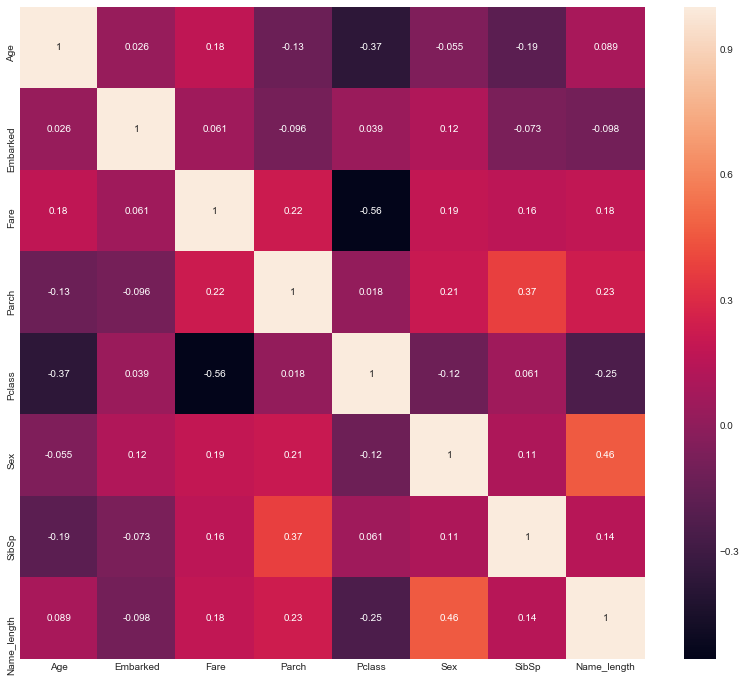

In [47]:
corr_df = pd.DataFrame(train_test[['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Name_length']])
plt.figure(figsize=(14, 12))
sns.heatmap(corr_df.astype(float).corr(), annot=True)

### Scaling Data

In [48]:
train_test[['Age', 'Fare', 'Name_length']] = StandardScaler().fit_transform(train_test[['Age','Fare', 'Name_length']])

In [49]:
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1,Title,Name_length
0,-0.595162,NaN,0,-0.503595,"Braund, Mr. Owen Harris",0,1,3,0,1,0,A/5 21171,1,0,0,1,0,Mr,-0.434672
1,0.646570,C85,1,0.734503,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1,PC 17599,0,1,0,0,1,Mrs,2.511806
2,-0.284729,NaN,0,-0.490544,"Heikkinen, Miss. Laina",0,3,3,1,0,1,STON/O2. 3101282,1,0,0,0,1,Miss,-0.539904
3,0.413745,C123,0,0.382925,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1,113803,1,0,0,0,1,Mrs,1.775186
4,0.413745,NaN,0,-0.488127,"Allen, Mr. William Henry",0,5,3,0,0,0,373450,1,0,0,1,0,Mr,-0.329441


### Splitting the data into train dataset and test dataset

In [50]:
data_backup = train_test.copy()
train_test.drop(['Cabin', 'Name', 'Ticket', 'Title', 'PassengerId'], axis=1, inplace=True)
# train_test.drop(['PassengerId'], axis=1, inplace=True)
train_test.drop(['Embarked', 'Sex'], axis=1, inplace=True)

In [51]:
train_test.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1,Name_length
0,-0.595162,-0.503595,0,3,1,0,1,0,0,1,0,-0.434672
1,0.646570,0.734503,0,1,1,1,0,1,0,0,1,2.511806
2,-0.284729,-0.490544,0,3,0,1,1,0,0,0,1,-0.539904
3,0.413745,0.382925,0,1,1,1,1,0,0,0,1,1.775186
4,0.413745,-0.488127,0,3,0,0,1,0,0,1,0,-0.329441


In [52]:
train_data, test_data = train_test[:891], train_test[891:]

In [53]:
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
X_test = test_data.drop('Survived', axis=1)

In [54]:
X_train.shape

(891, 11)

## Choose model

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(X_train, y_train, top_n_features):

    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = GridSearchCV(rf_est, rf_param_grid, n_jobs=25, cv=10, verbose=1)
    rf_grid.fit(X_train, y_train)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(X_train, y_train)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(X_train),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1]}
    ada_grid = GridSearchCV(ada_est, ada_param_grid, n_jobs=25, cv=10, verbose=1)
    ada_grid.fit(X_train, y_train)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(X_train, y_train)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(X_train),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [20]}
    et_grid = GridSearchCV(et_est, et_param_grid, n_jobs=25, cv=10, verbose=1)
    et_grid.fit(X_train, y_train)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(X_train, y_train)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(X_train),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))
    
    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = GridSearchCV(gb_est, gb_param_grid, n_jobs=25, cv=10, verbose=1)
    gb_grid.fit(X_train, y_train)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(X_train, y_train)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(X_train),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))
    
    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = GridSearchCV(dt_est, dt_param_grid, n_jobs=25, cv=10, verbose=1)
    dt_grid.fit(X_train, y_train)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(X_train, y_train)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(X_train),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))
    
    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt], 
                               ignore_index=True).drop_duplicates()
    
    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et, 
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)
    
    return features_top_n , features_importance

In [56]:
feature_to_pick = 10
feature_top_n, feature_importance = get_top_n_features(X_train, y_train, feature_to_pick)
X_train = pd.DataFrame(X_train[feature_top_n])
X_test = pd.DataFrame(X_test[feature_top_n])

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    6.8s remaining:    3.7s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    6.9s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best RF Score:0.8215488215488216
Top N Features RF Train Score:0.9887766554433222
Sample 10 Features from RF Classifier
1            Fare
0             Age
10    Name_length
9           Sex_1
8           Sex_0
3          Pclass
4           SibSp
2           Parch
5      Embarked_0
6      Embarked_1
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    6.7s remaining:    3.6s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    6.7s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.8047138047138047
Top N Features Ada Train Score:0.8294051627384961
Sample 10 Feature from Ada Classifier:
0             Age
1            Fare
10    Name_length
4           SibSp
3          Pclass
2           Parch
9           Sex_1
8           Sex_0
5      Embarked_0
6      Embarked_1
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    6.8s remaining:    3.7s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    6.8s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 500}
Top N Features Best ET Score:0.8249158249158249
Top N Features ET Train Score:0.9674523007856342
Sample 10 Features from ET Classifier:
9           Sex_1
8           Sex_0
10    Name_length
1            Fare
3          Pclass
0             Age
4           SibSp
2           Parch
6      Embarked_1
5      Embarked_0
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   25.0s remaining:   13.4s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   28.0s finished


Top N Features Best GB Params:{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.7586980920314254
Top N Features GB Train Score:0.9966329966329966
Sample 10 Feature from GB Classifier:
0             Age
1            Fare
10    Name_length
9           Sex_1
3          Pclass
8           Sex_0
2           Parch
4           SibSp
7      Embarked_2
5      Embarked_0
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 4}
Top N Features Best DT Score:0.7497194163860831
Top N Features DT Train Score:0.9652076318742986
Sample 10 Features from DT Classifier:
8           Sex_0
1            Fare
0             Age
10    Name_length
3          Pclass
4           SibSp
2           Parch
5      Embarked_0
6      Embarked_1
7      Embarked_2
Name: feature, dtype: object


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    0.2s finished


In [57]:
X_train.head(10)

,Fare,Age,Name_length,Sex_1,Sex_0,Pclass,SibSp,Parch,Embarked_0,Embarked_1,Embarked_2
0,-0.503595,-0.595162,-0.434672,0,1,3,1,0,1,0,0
1,0.734503,0.646570,2.511806,1,0,1,1,0,0,1,0
2,-0.490544,-0.284729,-0.539904,1,0,3,0,0,1,0,0
3,0.382925,0.413745,1.775186,1,0,1,1,0,1,0,0
4,-0.488127,0.413745,-0.329441,0,1,3,0,0,1,0,0
5,-0.480232,-0.065542,-1.171292,0,1,3,0,0,0,0,1
6,0.358997,1.888302,-0.434672,0,1,1,0,0,1,0,0
7,-0.236286,-2.147326,0.301947,0,1,3,3,1,1,0,0
8,-0.428510,-0.207121,2.301343,1,0,3,0,2,1,0,0
9,-0.062350,-1.216027,0.828104,1,0,2,1,0,0,1,0


## Model Ensemble

In [58]:
from sklearn.model_selection import KFold

# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 7 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state=SEED, shuffle=False)

def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=500, warm_start=True, max_features='sqrt',max_depth=6, 
                            min_samples_split=3, min_samples_leaf=2, n_jobs=-1, verbose=0)

ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)

et = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=8, min_samples_leaf=2, verbose=0)

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.008, min_samples_split=3, min_samples_leaf=2, max_depth=5, verbose=0)

dt = DecisionTreeClassifier(max_depth=8)

knn = KNeighborsClassifier(n_neighbors = 2)

svm = SVC(kernel='linear', C=0.025)

In [60]:
train_X = X_train.values
train_y = y_train.values
test_X = X_test.values

In [61]:
rf_train, rf_test = get_out_fold(rf, train_X, train_y, test_X)
ada_train, ada_test = get_out_fold(ada, train_X, train_y, test_X)
et_train, et_test = get_out_fold(et, train_X, train_y, test_X)
gb_train, gb_test = get_out_fold(gb, train_X, train_y, test_X)
dt_train, dt_test = get_out_fold(dt, train_X, train_y, test_X)
knn_train, knn_test = get_out_fold(knn, train_X, train_y, test_X)
svm_train, svm_test = get_out_fold(svm, train_X, train_y, test_X)

In [62]:
train_X = np.concatenate((rf_train, ada_train, et_train, gb_train, dt_train, knn_train, svm_train), axis=1)
test_X = np.concatenate((rf_test, ada_test, et_test, gb_test, dt_test, knn_test, svm_test), axis=1)

In [64]:
from xgboost import XGBClassifier

gbm = XGBClassifier(n_estimators=2000, max_depth=4, min_child_weight=2, gamma=.9,
                    subsample=.8, colsample_bytree=.8, objective="binary:logistic",
                    nthread=-1, scale_pos_weight=1).fit(train_X, train_y)
predictions = gbm.predict(test_X)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(418,)

In [66]:
submission = pd.DataFrame({"PassengerId": test_df_org['PassengerId'], "Survived": predictions})

In [68]:
submission.to_csv('submission.csv', index=False, sep=',')

## Draw the training curve

In [69]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [70]:
X = train_X
Y = train_y

# RandomForest
rf_parameters = {'n_jobs': -1, 'n_estimators': 500, 'warm_start': True, 'max_depth': 6, 'min_samples_leaf': 2, 
              'max_features' : 'sqrt','verbose': 0}

# AdaBoost
ada_parameters = {'n_estimators':500, 'learning_rate':0.1}

# ExtraTrees
et_parameters = {'n_jobs': -1, 'n_estimators':500, 'max_depth': 8, 'min_samples_leaf': 2, 'verbose': 0}

# GradientBoosting
gb_parameters = {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 2, 'verbose': 0}

# DecisionTree
dt_parameters = {'max_depth':8}

# KNeighbors
knn_parameters = {'n_neighbors':2}

# SVM
svm_parameters = {'kernel':'linear', 'C':0.025}

# XGB
gbm_parameters = {'n_estimators': 2000, 'max_depth': 4, 'min_child_weight': 2, 'gamma':0.9, 'subsample':0.8, 
               'colsample_bytree':0.8, 'objective': 'binary:logistic', 'nthread':-1, 'scale_pos_weight':1}

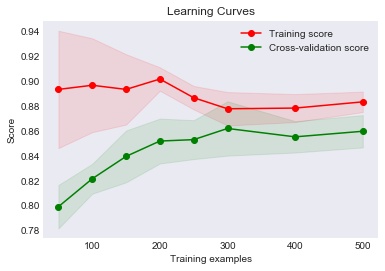

In [76]:
title = "Learning Curves"
plot_learning_curve(DecisionTreeClassifier(**dt_parameters), title, X, Y, cv=None, n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 300, 400, 500])
plt.show();